# Local Electronic Structure and Dynamics of Muon-Polaron Complexes in Fe$_2$O$_3$

## Supplemental material: Muon sites as a function of Hubbard U

M. H. Dehn$^{1, 2, 3}$ J. K. Shenton$^{4,*}$ D. J. Arseneau$^3$ W. A. MacFarlane$^{2, 3, 5}$ G.
D. Morris$^3$ A. Maigné$^2$ N. A. Spaldin$^4$, and R. F. Kiefl$^{1, 2, 3}$


$^1$Department of Physics and Astronomy, University of British Columbia, Vancouver, BC V6T 1Z1, Canada    
$^2$Stewart Blusson Quantum Matter Institute, University of British Columbia, Vancouver, BC V6T 1Z4, Canada    
$^3$<span style="font-variant:small-caps;">Triumf</span>, Vancouver, BC V6T 2A3, Canada   
$^4$Department of Materials, ETH Zurich, CH-8093 Zürich, Switzerland   
$^5$Department of Chemistry, University of British Columbia, Vancouver, BC, V6T 1Z1, Canada    




$^*$ For queries about the supplemental information in this notebook contact [J. Kane Shenton](mailto:john.shenton@mat.ethz.ch).

## Summary

In this notebook we look at how the predicted muon stopping site properties change with the value of the Hubbard $\mathrm{U_{eff}}$ correction applied to the Fe $d$ states. For the results presented in the paper, we employed a the LDA exchange-correlation functional together with a Hubbard correction of $\mathrm{U_{eff}}=4$ eV using the scheme of [Dudarev et al.](https://doi.org/10.1103/PhysRevB.57.1505) Here we explore $\mathrm{U_{eff}}$ values in the range $3-6$ eV.

We focus these tests on the charge-neutral sites (labelled C$^0_{\{1,2,3,4\}}$ in the paper) as we have several sites in which we can compare precession frequencies and relative energies in a straightforward manner.

We find that the predicted precession frequencies vary systematically with $\mathrm{U_{eff}}$ for all sites, changing by ~10MHz in the range of $\mathrm{U_{eff}}$ explored. The ordering in frequencies, however, remains the same throughout. 

The spread in energies of the different muon-polaron configurations decreases with increasing $\mathrm{U_{eff}}$. The energy ordering presented in the paper (consistent with our site assignment of the µSR signals) is maintained in the range: $\mathrm{U_{eff}} = 3-5$ eV. For $\mathrm{U_{eff}}=6$ eV, the C$^0_2$ site is found to be ~6 meV _lower_ in energy than the C$^0_1$ site rather than ~13 meV _higher_ in energy as presented in the paper. While a $\mathrm{U_{eff}}=6$ eV is very likely too large for Fe$_2$O$_3$, this finding emphasises that the sites C$^0_1$ and C$^0_2$ are very close in energy, again consistent with the interpretation of the µSR signals. 




The testing procedure was as follows for each value of $\mathrm{U_{eff}} = {3,4,5,6}$ eV:

1. Construct a copy of the sites found previously (C$^0_{\{1,2,3,4\}}$), with the unit cell scaled to the $\mathrm{U_{eff}}$-specific cell of pristine Fe$_2$O$_3$.

2. Fully relax the internal coordinates of all the ions in the cell. 

3. Run a single-point calculation to get the total energy and hyperfine tensor.

## Setup

In [1]:
# ASE version 3.19.1
from ase.io import read

# Numpy version 1.16.4
import numpy as np

# re version: 2.2.1
import re

# matplotlib version: 3.2.2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-talk')

%matplotlib inline

In order to make the repository size manageable, we have compressed the VASP input and output files. In order to run the notebook, first decompress the file by running the cell below:

In [10]:
!gzip -dr ./convergence_tests/muon_sites_wrt_U

In [2]:
def get_hyperfine(outcar, natoms, muon_index=-1):
    """
    Function to parse the vasp hyperfine tensor of the 'muon' from an OUTCAR file (final ionic step).
    
    Inputs:
        outcar (string): path to OUTCAR file
        natoms (int): total number of atoms in the cell
        muon_index (int): python index of the muon (typically the last atom in the POSCAR so defaults to -1)
    
    It returns the 
    """
    

    # muon gyromagnetic ratio:
    gamma_mu = 851.616 / (2*np.pi) # MHz /T

    re_totalspin  = re.compile("Total magnetic moment S")

    re_contact  = re.compile("Fermi contact \(isotropic\) hyperfine coupling parameter \(MHz\)")
    re_dipole   = re.compile("Dipolar hyperfine coupling parameters \(MHz\)")

    contacts = np.zeros(natoms)
    dipole_tensors = np.zeros((natoms, 3, 3))

    with open(outcar) as f:
        for line in f:
            if re_totalspin.search(line):
                totalS = float(line.split()[-1])

            if re_contact.search(line):
                next(f) # -------------------------------------------------------------
                next(f) #  ion      A_pw      A_1PS     A_1AE     A_1c      A_tot
                next(f) # -------------------------------------------------------------

                for i in range(natoms):
                    A_tot = float(next(f).split()[-1]) # just take the total contact interaction
                    contacts[i] = A_tot



            if re_dipole.search(line):
                next(f) # -------------------------------------------------------------
                next(f) #    ion      A_xx      A_yy      A_zz      A_xy      A_xz      A_yz
                next(f) # -------------------------------------------------------------

                for i in range(natoms):
                    A_dip = np.array((next(f).split())).astype(float)

                    # diagonal:
                    dipole_tensors[i][0][0] = A_dip[1]
                    dipole_tensors[i][1][1] = A_dip[2]
                    dipole_tensors[i][2][2] = A_dip[3]

                    #off-diagonal
                    dipole_tensors[i][0][1] = A_dip[4]
                    dipole_tensors[i][1][0] = A_dip[4]

                    dipole_tensors[i][0][2] = A_dip[5]
                    dipole_tensors[i][2][0] = A_dip[5]

                    dipole_tensors[i][1][2] = A_dip[6]
                    dipole_tensors[i][2][1] = A_dip[6]

    
    A_c = contacts[muon_index] * gamma_mu
    A_dip = dipole_tensors[muon_index] * gamma_mu
        
    A = A_dip + np.eye(3)*A_c
    
    # B-field
    Bfield = 0.5 * A[2]
    B_magnitude = np.linalg.norm(Bfield)

    # z-direction
    z = np.array([0,0,1])
    # get new theta
    theta = 180*np.arccos(np.array(Bfield).dot(z) / B_magnitude) / np.pi
    if theta > 90:
        theta = 180 - theta

    # Store Results 
    res = {'A_c'         : A_c,
           'A_dip'       : A_dip,
           'A'           : A,
           'Bfield'      : Bfield,
           'B_magnitude' : B_magnitude,
           'theta'       : theta}    
    
    return res
    

## Read in results

In [3]:
sites = range(1,5)
Ueffs = range(3,7)

muon_index = -1
verbose = False

results = {}

# loop over sites
for site in sites:
    print("\n")
    results[site] = {}
    # loop over U values
    for U in Ueffs:

        directory = f'./convergence_tests/muon_sites_wrt_U/C{site}/ueff-{U:02d}/scf_hf'
        outcar = directory + '/OUTCAR'

        print(f"Site: C{site}, Ueff = {U} eV")
        # read in OUTCAR as ASE atoms object
        atoms = read(outcar, format='vasp-out')

        # unit cell volume in Å^3
        volume = atoms.get_volume()

        #read in hyperfine tensor & related from OUTCAR
        hf_results = get_hyperfine(outcar, natoms = len(atoms))
        
        # local magnetic moments    
        mags = atoms.get_magnetic_moments()
        femags = mags[:32]
        most_magind, next_magind = np.argsort(abs(femags))[:2]


        # vector from COM to muon
        com = atoms.get_center_of_mass()
        muon_pos = atoms.positions[-1]

        vec = muon_pos - com

        results[site][U] = {'hf'                : hf_results,
                            'mags'              : mags,
                            'most_polaron'      : most_magind,
                            'next_most_polaron' : next_magind,
                            'com2muon'          : vec,
                            'volume'            : volume,
                            'energy'            : atoms.get_potential_energy()}



Site: C1, Ueff = 3 eV
Site: C1, Ueff = 4 eV
Site: C1, Ueff = 5 eV
Site: C1, Ueff = 6 eV


Site: C2, Ueff = 3 eV
Site: C2, Ueff = 4 eV
Site: C2, Ueff = 5 eV
Site: C2, Ueff = 6 eV


Site: C3, Ueff = 3 eV
Site: C3, Ueff = 4 eV
Site: C3, Ueff = 5 eV
Site: C3, Ueff = 6 eV


Site: C4, Ueff = 3 eV
Site: C4, Ueff = 4 eV
Site: C4, Ueff = 5 eV
Site: C4, Ueff = 6 eV


## Muon precession frequencies

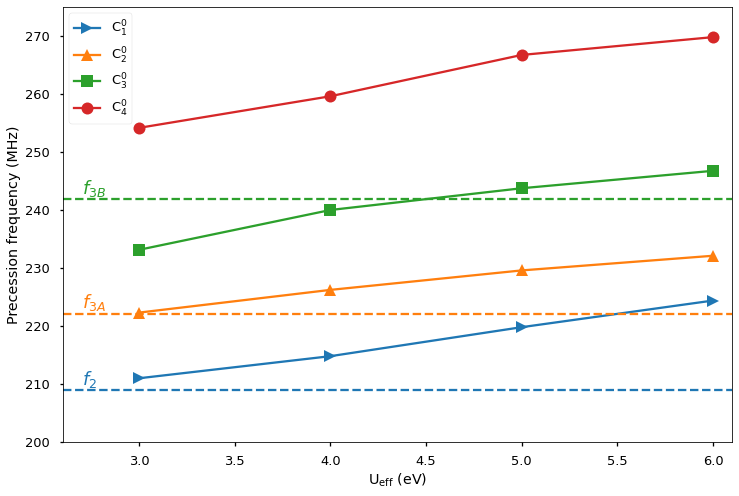

In [4]:
sites = range(1,5)
Ueffs = range(3,7)

colors = ['C0', 'C1', 'C2', 'C3']
markers = ['>', '^', 's', 'o']



# plot
fig, ax = plt.subplots(figsize=(12,8))

for isite, site in enumerate(sites):
    freqs = [results[site][U]['hf']['B_magnitude'] for U in Ueffs]
    ax.plot(Ueffs, freqs,
           marker = markers[isite],
           color = colors[isite],
           markersize = 12,
           label = f"C$^0_{site}$")

# Experimental values
exp_C1 = 208.9
exp_C2 = 222.1
exp_C3 = 241.8

ax.axhline(exp_C1, linestyle = '--', color=colors[0])
ax.text(2.70, exp_C1+1, '$f_2$', color=colors[0], fontsize=18)
ax.axhline(exp_C2, linestyle = '--', color=colors[1])
ax.text(2.70, exp_C2+1, '$f_{3A}$', color=colors[1], fontsize=18)
ax.axhline(exp_C3, linestyle = '--', color=colors[2])
ax.text(2.70, exp_C3+1, '$f_{3B}$', color=colors[2], fontsize=18)

ax.set_xlim([2.6,6.1])
ax.set_ylim([200,275])
ax.legend()
ax.set_xlabel(r"$\mathrm{U_{eff}}$ (eV)")
ax.set_ylabel("Precession frequency (MHz)");


We find:

1. A nearly linear increase in predicted precession frequency with increasing $\mathrm{U_{eff}}$. 
2. The predicted precession frequencies remain separated by roughly the same amount for each value of $\mathrm{U_{eff}}$. The ordering in precession frequencies remains constant for each value of $\mathrm{U_{eff}}$.
3. The magnitude of the precession frequencies change by ~ 10 MHz in the range of $\mathrm{U_{eff}}$ values explored.


Let's see if we can explain the increase in muon precession frequency based on the increase in local magnetic moments of Fe$_2$O$_3$ with increasing $\mathrm{U_{eff}}$.


## Magnetic moments

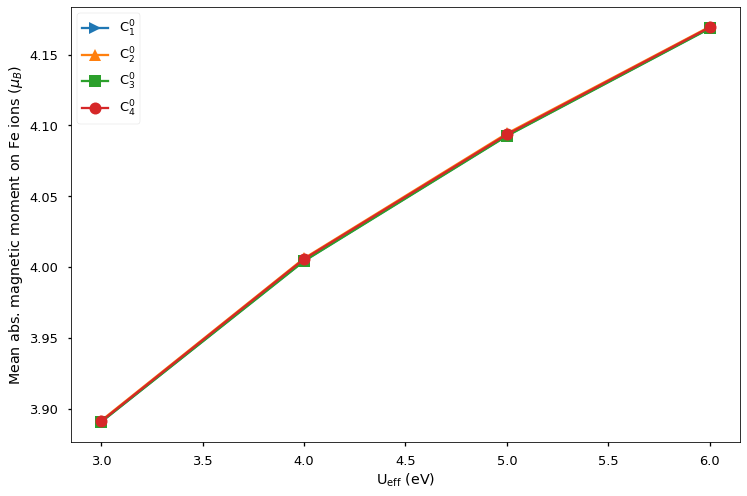

In [6]:
C1_mags = np.array([abs(results[1][U]['mags'][:32]).mean() for U in Ueffs])
C2_mags = np.array([abs(results[2][U]['mags'][:32]).mean() for U in Ueffs])
C3_mags = np.array([abs(results[3][U]['mags'][:32]).mean() for U in Ueffs])
C4_mags = np.array([abs(results[4][U]['mags'][:32]).mean() for U in Ueffs])


sites = range(2,5)
Ueffs = range(3,7)

colors = ['C0', 'C1', 'C2', 'C3']
markers = ['>', '^', 's', 'o']



# plot
fig, ax = plt.subplots(figsize=(12,8))


for isite, site_mags in enumerate([C1_mags, C2_mags, C3_mags, C4_mags]):
    # plot
    ax.plot(Ueffs, site_mags,
           marker = markers[isite],
           color = colors[isite],
           markersize = 12,
           label = f"C$^0_{isite+1}$")


ax.legend()
ax.set_xlabel(r"$\mathrm{U_{eff}}$ (eV)")
ax.set_ylabel("Mean abs. magnetic moment on Fe ions ($\mu_B$)");

In [7]:
# The percent change in frequency of each site when increasing Ueff from 3 to 6 eV
deltaC1 = 100*(results[1][6]['hf']['B_magnitude'] - results[1][3]['hf']['B_magnitude']) / results[1][3]['hf']['B_magnitude']
deltaC2 = 100*(results[2][6]['hf']['B_magnitude'] - results[2][3]['hf']['B_magnitude']) / results[2][3]['hf']['B_magnitude']
deltaC3 = 100*(results[3][6]['hf']['B_magnitude'] - results[3][3]['hf']['B_magnitude']) / results[3][3]['hf']['B_magnitude']
deltaC4 = 100*(results[3][6]['hf']['B_magnitude'] - results[3][3]['hf']['B_magnitude']) / results[3][3]['hf']['B_magnitude']


# The percent change in mean local mag. moments on Fe of each muon site when increasing Ueff from 3 to 6 eV
def get_mean_mag(isite, U):
    """
    Just to make things look neater, we define a function to return the mean mag. moments.
    """
    return abs(results[isite][U]['mags'][:32]).mean()
    
deltaC1_mags = 100*(get_mean_mag(1, 6) - get_mean_mag(1, 3)) / get_mean_mag(1, 3)
deltaC2_mags = 100*(get_mean_mag(2, 6) - get_mean_mag(2, 3)) / get_mean_mag(2, 3)
deltaC3_mags = 100*(get_mean_mag(3, 6) - get_mean_mag(3, 3)) / get_mean_mag(3, 3)
deltaC4_mags = 100*(get_mean_mag(4, 6) - get_mean_mag(4, 3)) / get_mean_mag(4, 3)



print(f"  C1    C2    C3    C4 ")
print(f"{deltaC1:4.1f}  {deltaC2:4.1f}  {deltaC3:4.1f}  {deltaC4:4.1f} % change in freq.")
print(f"{deltaC1_mags:4.1f}  {deltaC2_mags:4.1f}  {deltaC3_mags:4.1f}  {deltaC4_mags:4.1f} % change in mag. moments")



print("\n\nMean change in precession freq. across all sites: ")
print(f"{(deltaC1 +deltaC2 +deltaC3 + deltaC4) / 4:4.1f} %")
print("Mean change in local magnetic moments on the Fe ions:")
print(f"{(deltaC1_mags +deltaC2_mags +deltaC3_mags + deltaC4_mags) / 4:4.1f} %")


  C1    C2    C3    C4 
 6.4   4.4   5.8   5.8 % change in freq.
 7.2   7.2   7.1   7.2 % change in mag. moments


Mean change in precession freq. across all sites: 
 5.6 %
Mean change in local magnetic moments on the Fe ions:
 7.2 %


So the general tendency of $\mathrm{U_{eff}}$ to increase the local mag. moments on the Fe ions is goes a long way to explaining the variation in predicted muon precession frequencies. The remaining variation might be due to structural changes$^*$ and changes in the distribution of the spin density in the muon's immediate neighbourhood (particularly the localisation of the polaron). 


$^*$In particular the unit cell volume increases with $\mathrm{U_{eff}}$ in this range. An increase in volume effectively means the muons become further away from the magnetic ions and thus the increase in local field at the muon site is less than what might be expected from the increase in magnetic moments alone. 

## Site energies

In the paper, we also present differences in energies of the charge neutral sites. The ordering (and to some extent the magnitudes) are consistent with frequency-based assignment of the sites and the observed temperature dependence of the µSR signals.

Here we look at the sensitivity of such energy differences to the choice of $\mathrm{U_{eff}}$. 


Note that energy differences for calculations with different $\mathrm{U_{eff}}$ are not physically meaningful. Instead, what we plot below is, for each value of $\mathrm{U_{eff}}$, the relative energy of the different muon sites.


Site: C2
     U = 3    U = 4    U = 5    U = 6      eV
dE =  24.2     12.8     11.9     -5.7     meV

Site: C3
     U = 3    U = 4    U = 5    U = 6      eV
dE =  42.8     37.5     28.8     23.2     meV

Site: C4
     U = 3    U = 4    U = 5    U = 6      eV
dE =  56.2     50.7     54.4     47.4     meV


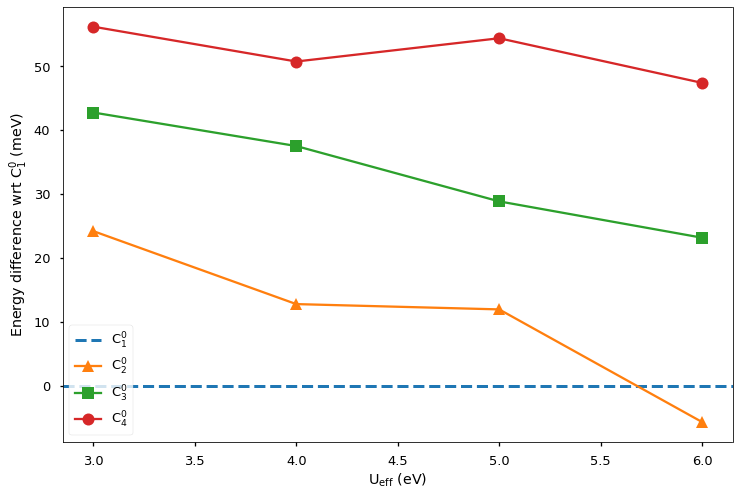

In [8]:
sites = range(2,5)
Ueffs = range(3,7)

colors = ['C0', 'C1', 'C2', 'C3']
markers = ['>', '^', 's', 'o']

# plot
fig, ax = plt.subplots(figsize=(12,8))

# Extract the energies for each site:
C1_energies = np.array([results[1][U]['energy'] for U in Ueffs])
C2_energies = np.array([results[2][U]['energy'] for U in Ueffs])
C3_energies = np.array([results[3][U]['energy'] for U in Ueffs])
C4_energies = np.array([results[4][U]['energy'] for U in Ueffs])


# C1 will be the reference energy,
# so plot a dashed horizontal line to represent this.
ax.axhline(0,
           linestyle='--',
           color='C0',
           linewidth = 3,
           label = 'C$^0_1$')

# Loop over sites C2, C3 and C4
for isite, site in enumerate(sites):

    #energies of site wrt those of C1, converting to meV with the factor of 1000
    energies = 1000*(np.array([results[site][U]['energy'] for U in Ueffs]) - C1_energies)

    # Print out the actual values for reference:
    print(f"\nSite: C{site}")
    print("     U = 3    U = 4    U = 5    U = 6      eV")
    print("dE = {:5.1f}    {:5.1f}    {:5.1f}    {:5.1f}     meV".format(*energies))
    
    # plot
    ax.plot(Ueffs, energies,
           marker = markers[isite+1],
           color = colors[isite+1],
           markersize = 12,
           label = f"C$^0_{site}$")


ax.legend()
ax.set_xlabel(r"$\mathrm{U_{eff}}$ (eV)")
ax.set_ylabel("Energy difference wrt C$^0_1$ (meV)");

We find that:

1. The energy ordering as found in the paper is maintained for the $\mathrm{U_{eff}}$ values in the ~3-5 eV range. For $\mathrm{U_{eff}}=6$ eV, we find that the C2 site is lower in energy than C1 by ~6 meV. 
2. The relative energies of the sites vary significantly over the range of $\mathrm{U_{eff}}$ explored. The sites get closer in energy with increasing $\mathrm{U_{eff}}$. 

## Unit cell volume

Since the unit cell volume changes as a function of $\mathrm{U_{eff}}$, for each calculation, the unit cell volume of pristine (no muon or polaron) Fe$_2$O$_3$, relaxed with that value of $\mathrm{U_{eff}}$, was used. and the ionic positions were fully relaxed. Below we print out the volume of the cell for each case for ease of reference.

In [9]:
for isite, site in enumerate(sites):
    print('site: ', site)
    for U in Ueffs:
        V = results[site][U]['volume']
        print(f"{V:12.4f} Å^3")

site:  2
    765.8117 Å^3
    771.1683 Å^3
    774.8557 Å^3
    777.1531 Å^3
site:  3
    765.8117 Å^3
    771.1683 Å^3
    774.8557 Å^3
    777.1531 Å^3
site:  4
    765.8117 Å^3
    771.1683 Å^3
    774.8557 Å^3
    777.1531 Å^3
